In [ ]:
!pip install -r requirements.txt

## State contains the persistent mutable variables across the graph 

State is passed

In [2]:
from typing import List, Annotated, Optional
from pydantic import BaseModel, Field
from operator import add
from datetime import datetime

def increment(a:int,b:int)-> int:
    return a+1

#Create a message model
class Message(BaseModel):
    message : str
    timestamp : datetime = Field(default_factory=datetime.now)
    source : str
    
#Define a simple state
#States get updated by reduce, by default parameters get replaced. If we provide a reduction function with Annotated type, this function will be called to update the state
class GraphState(BaseModel):
    # While this happens by default, we created a message history which will append to our list
    message_history: Annotated[List[Message], add] = Field(default_factory = list)
    test_flag: bool = False
    #Counter - this will increase by one at each update of the graph state
    counter: Annotated[int, increment] = 0

# Nodes

Nodes act on the graph state by the function they are defined by

In [3]:
#We define our first node function - user message
from langgraph.types import interrupt

def user_input_node(state:GraphState):
    user_message = input(
        "Type your message:"
    )
    state.message_history = [Message(
        message = user_message,
        source = "User"
    )]
    return state

In [8]:
from langgraph.graph import START, END, StateGraph
# Create an initial StateGraph
graph_builder = StateGraph(GraphState)

graph_builder.add_node("single_node - user_input", user_input_node)

graph_builder.add_edge(START,"single_node - user_input")
graph_builder.add_edge("single_node - user_input", END)

# Compile the graph
app = graph_builder.compile()

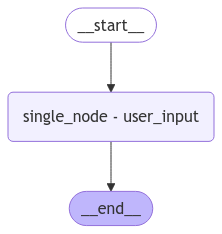

In [9]:
#Create a mermaid diagram of the graph - we need to import IPython.display to display it in Jupyter
mermaid_str = app.get_graph().draw_mermaid()

from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# Let's run our single node graph 

results = app.invoke(input = GraphState.model_construct())

for item in results.items():
    print(item)

In [12]:
#Let's load our model and key - we will use the test_agent client to make LLM calls.

#Ignore this code section

from pathlib import Path
from typing import Tuple
import os
from dotenv import load_dotenv

def load_llm_config() -> Tuple[str, str]:
    """
    Load LLM provider and API key from environment variables or .env file.
    Prioritizes environment variables over .env file settings.
    
    Returns:
        Tuple[str, str]: (provider, api_key)
    
    Raises:
        KeyError: If required configuration is missing from both sources
        ValueError: If provider or API key validation fails
    """
    # Load .env file if it exists (as fallback)
    env_path = Path('.env')
    if env_path.exists():
        load_dotenv()
    
    # Try environment variables first, then fall back to loaded .env values
    provider = os.getenv('LLM_PROVIDER')
    api_key = os.getenv('LLM_API_KEY')
    
    # Check if either value is missing
    missing_vars = []
    if not provider:
        missing_vars.append('LLM_PROVIDER')
    if not api_key:
        missing_vars.append('LLM_API_KEY')
    
    if missing_vars:
        raise KeyError(
            f"Missing required configuration: {', '.join(missing_vars)}. "
            "Please set environment variables or create .env file."
        )
    
    # Validate provider
    valid_providers = {"AI Studio", "Claude", "OpenAI", "DeepSeek"}
    if provider not in valid_providers:
        raise ValueError(
            f"Invalid provider '{provider}'. "
            f"Must be one of: {', '.join(valid_providers)}"
        )
    
    # Validate API key is not empty
    if not api_key.strip():
        raise ValueError("API key cannot be empty")
        
    return provider, api_key


# Nest asyncio is required as Pydantic uses an asyncrounous call - and jupyter is asyncrounous by default.
import nest_asyncio
nest_asyncio.apply()

from pydantic_ai.models.anthropic import AnthropicModel
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.models.gemini import GeminiModel #This is recommended for testing only - for production use VertexAI
from pydantic_ai import Agent

success = False
while not success:
    provider, api_key = load_llm_config()

    match provider:
        case "AI Studio":
            model = GeminiModel(
                "gemini-2.0-flash-exp",
                api_key  = api_key
            )
        case "Claude":
            model = AnthropicModel(
                "claude-3-5-sonnet-latest",
                api_key  = api_key
            )
        case "OpenAI":
            model = OpenAIModel(
                "gpt-4o",
                api_key  = api_key
            )
        case "DeepSeek": 
            model = OpenAIModel(
                "DeepSeek-V3",
                base_url = "https://api.deepseek.com/v1",
                api_key  = api_key
            )
        #Define a test agent for testing.
    test_agent = Agent(model)
    try:
        # This is why we need the nest_asyncio
        response = test_agent.run_sync(
            user_prompt = "Test call")
        print(f"Response received successfully from {provider}!")

        print(response.data)
        success = True
    except:
        print("Invalid API key")


Response received successfully from AI Studio!
Okay, I hear you! This sounds like a test call. Is there anything you'd like to test specifically? 

For example, are you testing:

* **My responsiveness?** I'm here and ready to go.
* **My understanding?** Feel free to ask me anything.
* **My ability to generate different types of content?** We can try that.
* **Something else?** Let me know what's on your mind!

Let me know how I can help you with your test call!



In [14]:
#Lets add an LLM model node to respond in our graph.
# We will simply call the agent with the last response as an input message
def agent_call_node(state:GraphState)-> GraphState:
    last_message = state.message_history[-1].message
    response = test_agent.run_sync(
        user_prompt = last_message
    )
    return GraphState(
        message_history = [Message(
            message = response.data,
            source = "agent"
        )],
        test_flag = True
    )


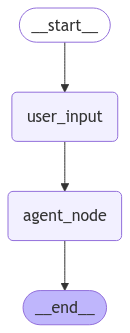

In [15]:
# We are building out our chained
from langgraph.graph import START, END, StateGraph
# A single chained graph
graph_builder = StateGraph(GraphState)

graph_builder.add_node("user_input", user_input_node)
graph_builder.add_node("agent_node", agent_call_node)


graph_builder.add_edge(START,"user_input")
graph_builder.add_edge("user_input", "agent_node")
graph_builder.add_edge("agent_node", END)


# Compile the graph
app = graph_builder.compile()

#Creat
mermaid_str = app.get_graph().draw_mermaid()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# Let's test how the chained graph behaves

results = app.invoke(input = GraphState.model_construct())
print(results["message_history"])
for item in results["message_history"]:
    print(item)

print(results["counter"])

In [60]:
# Now let's check - how we branch our graph - conditional routing
from pydantic_ai import Agent
# Redefine our agent nodes for the sake of the example
# We will have 3 catogories - question, task, instruction - which will be handed off to different agents

# Let's define our graph router

def graph_router(state:GraphState):
    last_response = state.message_history[-1].message.lower()
    if "question" in last_response:
        return "question"
    elif "task" in last_response:
        return "task"
    elif "instruction" in last_response:
        return "instruction"
    else:
        raise Exception("incorrect or missing category")

# Let's define our nodes and LLM calls(we wrap it in 'agents')

categorization_agent = Agent(
    model,
    system_prompt = """
    Categorize the user request into one of the following categories : 
    1. Question,
    2. Task,
    3. Instruction
    """)

def categorization_node(state:GraphState):
    response = categorization_agent.run_sync(state.message_history[-1].message)
    print(response)
    return {
        "message_history" : [Message(message=response.data, source= "agent")]
    }

question_agent = Agent(
    model,
    system_prompt = """
    Answer the user question
    """)

def question_node(state:GraphState):
    response = question_agent.run_sync(state.message_history[-1].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")]
    }

task_agent = Agent(
    model,
    system_prompt = """
    Complete the task provided
    """)

def task_node(state:GraphState):
    response = task_agent.run_sync(state.message_history[-1].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")]
    }

instruction_agent = Agent(
    model,
    system_prompt = """
    Follow the instruction provided
    """)

def instruction_node(state:GraphState):
    response = instruction_agent.run_sync(state.message_history[-1].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")]
    }




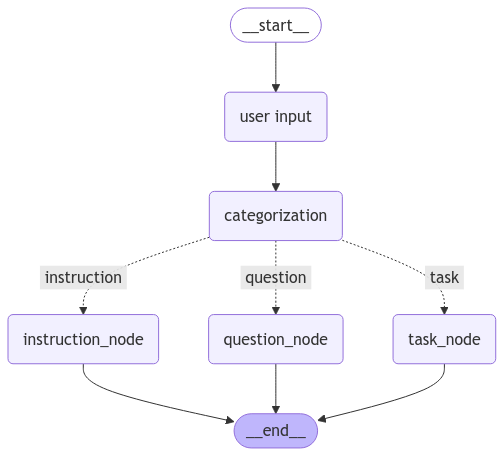

In [61]:
# Lets build our graph quickly

routing_graph_builder = StateGraph(GraphState)
#Lets define our nodes
routing_graph_builder.add_node("user input", user_input_node)
routing_graph_builder.add_node("categorization", categorization_node)
routing_graph_builder.add_node("question_node", question_node)
routing_graph_builder.add_node("task_node", task_node)
routing_graph_builder.add_node("instruction_node", instruction_node)

# Let's define our edges
routing_graph_builder.add_edge(START,"user input")
routing_graph_builder.add_edge("user input","categorization")
routing_graph_builder.add_conditional_edges(
    "categorization",
    graph_router,
    {
        "question": "question_node", 
        "task":"task_node" , 
        "instruction": "instruction_node"}
    )

routing_graph_builder.add_edge("question_node",END)
routing_graph_builder.add_edge("task_node",END)
routing_graph_builder.add_edge("instruction_node",END)

# Let's draw our graph

# Compile the graph
router_app = routing_graph_builder.compile()

#Creat
mermaid_str = router_app.get_graph().draw_mermaid()

try:
    display(Image(router_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# Let's run our model with streamed responses

events = router_app.stream(input = GraphState.model_construct(), stream_mode="updates")
print(events)
for s in events:
    try:
        print(s)
    except:
        pass
    for items in s.values():
      try:
        print(items)
      except:
        pass
